In [3]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import random

In [4]:
# activation will store the features (batched)
activation = None

# hook to get feature vector in forward pass
def hook(model, input, output):
    global activation
    activation = input

number_of_samples = 100000

global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])

features_filename = '/scratch/features.hdf5'

device = 'cuda'

# get best model
model = models.resnext50_32x4d(pretrained=True, progress=True)
model.fc = torch.nn.Linear(model.fc.in_features, 1)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.to(device)

best_model_path = '/projectnb/ece601/kaggle-pulmonary-embolism/cliao25/EC601-Pulmonary-Embolism/SequenceModeling/exp-4-SGD/model-resnext-50-28.pth'
model.load_state_dict(torch.load(best_model_path))

model.fc.register_forward_hook(hook)


In [5]:
valid_samples = 26540
samples_per_split = 100000
train_samples = 70000

class KagglePEDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage, transform=None, split=0):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        self.pos_df = self.pedataframe[self.pedataframe.pe_present_on_image == 1]
        self.split_df = self.pedataframe[split*samples_per_split : (split+1)*samples_per_split]
        self.neg_df = self.split_df[self.split_df.pe_present_on_image == 0]
        self.transform = transform
        self.stage = stage
        
        # data is divided into sets of 100,000 2D slices
        #
        # Negative samples:
        # split 0,1,2,3,4,5 used for training
        # split 6,7 used for validation
        # pick 70,000 negative samples from the 100,000 slices (samples without replacement)
        #
        # Positive samples:
        # npy-pe-pos.hdf5
        # total 96,540 positive samples
        # pick 70,000 for training
        # 26,540 for validation
        #
        # For each dataset, combine the positive and negatives,then shuffle.
        
        self.split = split
        
        # copy file to scratch space on the fly
        # Uncomment for copy on the fly (only do this if not enough scraatch space)
        # copyfile('npy-' + str(split + 1) + '.hdf5', '/scratch/npy-' + str(split + 1) + '.hdf5')
        
        # sample 70,000 slices from this file
        self.split_hdf5_filename = '/scratch/npy-' + str(split + 1) + '.hdf5'
    
    def destroy(self):
        ''' For copy on the fly (when scratch space insufficient)'''
        os.remove(self.filename )

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        return 100000
    
    def get_class_weights(self):
        subset = self.pedataframe[:len(self)]
        pos = subset[subset.pe_present_on_image == 1]
        neg = subset[subset.pe_present_on_image == 0]
        return 1. / torch.tensor([len(neg), len(pos)], dtype=torch.float)
    
    def get_targets(self):
        subset = self.pedataframe[:len(self)]
        return torch.tensor(subset.pe_present_on_image, dtype=torch.long)
    
    def center_crop(self, crop_size, img):
        row = (img.shape[-2] - crop_size) // 2
        col = (img.shape[-1] - crop_size) // 2
        img = img[row : row + crop_size, col : col + crop_size]
        return img
    
    def random_crop(self, crop_size, img):
        row = random.randint(0, img.shape[-2] - crop_size)
        col = random.randint(0, img.shape[-1] - crop_size)
        img = img[row : row + crop_size, col : col + crop_size]
        return img
    
    def random_flip(self, img):
        r = random.randint(0,1)
        if r == 0:
            img = np.copy(np.flipud(img))
        return img

    def __getitem__(self, idx):
        ''' idx is index into dataframe. '''
        
        idx = idx + self.split*100000

        data_identifier = self.pedataframe.StudyInstanceUID[idx] + \
            '/' + self.pedataframe.SOPInstanceUID[idx]
        
        # look for image in negative dataset
        h5py_file = h5py.File(self.split_hdf5_filename, "r")
        
        img = h5py_file[data_identifier][:]
        
        #resize 512x512 -> 256x256
        img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
        
        # center crop 224
        if self.stage == 'train':
            img = self.random_crop(224, img)
            img = self.random_flip(img)
        else:
            img = self.center_crop(224, img)

        # unsqueeze to add channel dimension
        img = torch.tensor(img, dtype=torch.float).unsqueeze(0)
        h5py_file.close()
        
        return self.transform(img), idx

In [8]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_df = pd.read_csv(train_csv)

global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])
#pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', transform=transform, split=0)

#image, idx = pe_dataset[5]
#image = image.squeeze(0)
#fig, ax = plt.subplots(1,2,figsize=(10,5))
#ax[0].imshow(image)
#sns.distplot(image.flatten(), ax=ax[1]);

In [9]:
len(pe_dataset)

100000

In [10]:
model.eval()
batch_size = 32

In [11]:
model.eval()

h5py_features_file = h5py.File(features_filename, "a")
batch_size = 32
loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)

with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()
        

100%|██████████| 3125/3125 [05:11<00:00, 10.04it/s]


100%|██████████| 3125/3125 [05:59<00:00,  8.70it/s]


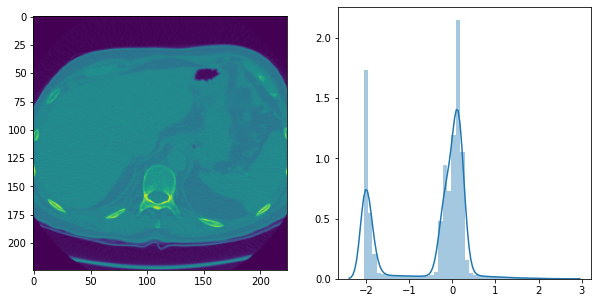

In [7]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', transform=transform, split=1)

image, idx = pe_dataset[5]
image = image.squeeze(0)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
sns.distplot(image.flatten(), ax=ax[1]);

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()


100%|██████████| 3125/3125 [04:50<00:00, 10.75it/s]


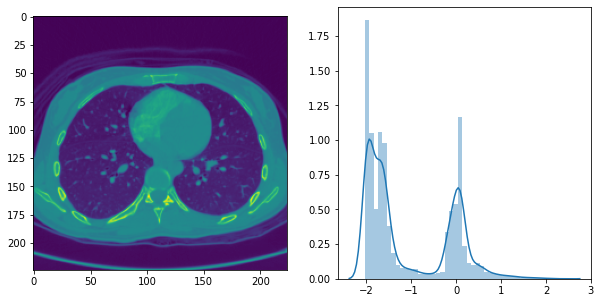

In [12]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', transform=transform, split=2)

image, idx = pe_dataset[5]
image = image.squeeze(0)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
sns.distplot(image.flatten(), ax=ax[1]);

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()

In [7]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', transform=transform, split=3)

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])

h5py_features_file.close()

NameError: name 'batch_size' is not defined

In [12]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', 
                             transform=transform, split=4)

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()

100%|██████████| 3125/3125 [05:06<00:00, 10.21it/s]


In [13]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', 
                             transform=transform, split=5)

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()

100%|██████████| 3125/3125 [03:54<00:00, 13.34it/s]


In [14]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', 
                             transform=transform, split=6)

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()

100%|██████████| 3125/3125 [07:05<00:00,  7.35it/s]


In [15]:
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='valid', 
                             transform=transform, split=7)

loader = torch.utils.data.DataLoader(pe_dataset, batch_size=batch_size, num_workers=1)
h5py_features_file = h5py.File(features_filename, "a")
with torch.no_grad():
    for (data, idx) in tqdm(loader):
        data = data.to(device)
        _ = model(data)
        
        # activation[0] is Bx2048. Store this vector
        activation = activation[0].detach().cpu()
        
        for sample in range(batch_size):
            sample_idx = idx[sample] # index into dataframe
            h5py_features_file.create_dataset(str(sample_idx), data=activation[sample,:])
h5py_features_file.close()

100%|██████████| 3125/3125 [02:47<00:00, 18.67it/s]


In [30]:
len(h5py_features_file.keys())

800000